# Fire_scar_pipeline_v1

In [ ]:
import osgeo.gdal as gdal
import os
from osgeo import ogr

# this sets the environmental variables for the prj folders 
# https://stackoverflow.com/questions/56764046/gdal-ogr2ogr-cannot-find-proj-db-error


os.environ['PROJ_LIB'] =  r'C:\ProgramData\Anaconda3\envs\geo_env\Library\share\proj'
os.environ['GDAL_DATA'] = r'C:\ProgramData\Anaconda3\envs\geo_env\Library\share'

In [1]:
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob

import numpy as np
import rasterio as rio
import rasterio.plot
import pyproj

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import fiona
import rasterstats
from rasterstats import zonal_stats

# NAFI 2020 raster clasification

https://www.neonscience.org/resources/data-tutorials

https://www.neonscience.org/classify-raster-thresholds-py

In [2]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
nafi_filename = r"Z:\Scratch\Zonal_Stats_Pipeline\Firescars\NAFI_fire_rasters_v2\fs2020.tif"
nafi_dataset = gdal.Open(nafi_filename)

In [4]:
#Display the dataset dimensions, number of bands, driver, and geotransform 
cols = nafi_dataset.RasterXSize; print('# of columns:',cols)
rows = nafi_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',nafi_dataset.RasterCount)
print('driver:',nafi_dataset.GetDriver().LongName)

# of columns: 16431
# of rows: 9868
# of bands: 1
driver: GeoTIFF


In [5]:
print('projection:',nafi_dataset.GetProjection())

projection: 


In [6]:
print('geotransform:',nafi_dataset.GetGeoTransform())

geotransform: (112.9225, 0.0025, 0.0, -9.329999999999998, 0.0, -0.0025)


In [7]:
nafi_mapinfo = nafi_dataset.GetGeoTransform()
xMin = nafi_mapinfo[0]
yMax = nafi_mapinfo[3]

xMax = xMin + nafi_dataset.RasterXSize/nafi_mapinfo[1] #divide by pixel width 
yMin = yMax + nafi_dataset.RasterYSize/nafi_mapinfo[5] #divide by pixel height (note sign +/-)
nafi_ext = (xMin,xMax,yMin,yMax)
print('nafi raster extent:',nafi_ext)

nafi raster extent: (112.9225, 6572512.9225, -3947209.33, -9.329999999999998)


In [8]:
nafi_raster = nafi_dataset.GetRasterBand(1)
noDataVal = nafi_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = nafi_raster.GetScale(); print('scale factor:',scaleFactor)
nafi_stats = nafi_raster.GetStatistics(True,True)
print('SERC nafi Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (nafi_stats[0], nafi_stats[1], nafi_stats[2], nafi_stats[3]))

no data value: 255.0
scale factor: 1.0
SERC nafi Statistics: Minimum=0.00, Maximum=157.00, Mean=1.029, StDev=9.614


In [9]:
nafi_array = nafi_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
nafi_array[nafi_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
nafi_array=nafi_array/scaleFactor
print('NAFI Array:\n',nafi_array) #display array values

NAFI Array:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# Display statistics (min, max, mean); numpy.nanmin calculates the minimum without the NaN values.
print('Array Statistics:')
print('min:',round(np.nanmin(nafi_array),2))
print('max:',round(np.nanmax(nafi_array),2))
print('mean:',round(np.nanmean(nafi_array),2))

# Calculate the % of pixels that are NaN and non-zero:
pct_nan = np.count_nonzero(np.isnan(nafi_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(nafi_array)/(rows*cols),2))

Array Statistics:
min: 0.0
max: 157.0
mean: 0.99
% NaN: 0.0
% non-zero: 1.43


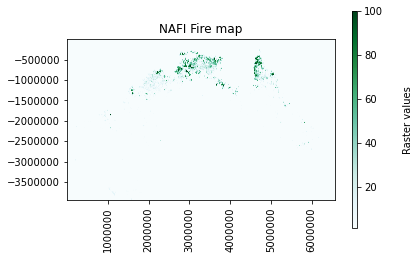

In [11]:
# Define the plot_band_array function from Day 1
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='BuGn'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    
plot_band_array(nafi_array,nafi_ext,(1,100),title='NAFI Fire map',cmap_title='Raster values')

Text(0, 0.5, 'Relative Frequency')

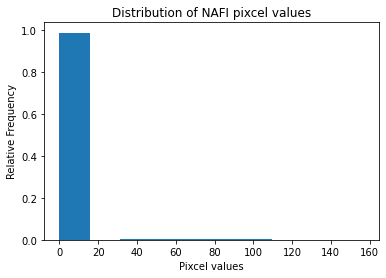

In [12]:
import copy
nafi_nonan_array = copy.copy(nafi_array)
nafi_nonan_array = nafi_nonan_array[~np.isnan(nafi_array)]
plt.hist(nafi_nonan_array,weights=np.zeros_like(nafi_nonan_array)+1./
         (nafi_array.shape[0]*nafi_array.shape[1]),bins=10);
plt.title('Distribution of NAFI pixcel values')
plt.xlabel('Pixcel values'); plt.ylabel('Relative Frequency')

min: 1.0 m
max: 157.0 m
mean: 69.08 m


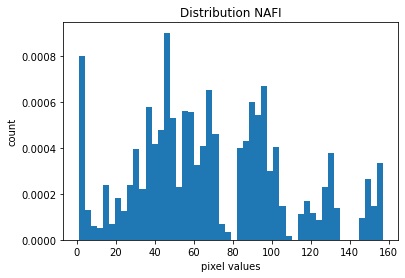

In [13]:
nafi_nonzero_array = copy.copy(nafi_array)
nafi_nonzero_array[nafi_array==0]=np.nan
chm_nonzero_nonan_array = nafi_nonzero_array[~np.isnan(nafi_nonzero_array)]
# Use weighting to plot relative frequency
plt.hist(chm_nonzero_nonan_array,weights=np.zeros_like(chm_nonzero_nonan_array)+1./
         (nafi_array.shape[0]*nafi_array.shape[1]),bins=50);

# plt.hist(chm_nonzero_nonan_array.flatten(),50) 
plt.title('Distribution NAFI')
plt.xlabel('pixel values'); plt.ylabel('count')
# plt.xlim(0,25); plt.ylim(0,4000000)

print('min:',np.amin(chm_nonzero_nonan_array),'m')
print('max:',round(np.amax(chm_nonzero_nonan_array),2),'m')
print('mean:',round(np.mean(chm_nonzero_nonan_array),2),'m')

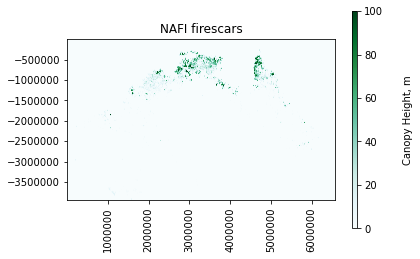

In [20]:
plot_band_array(nafi_array,nafi_ext,(0,100),title='NAFI firescars',cmap_title='Canopy Height, m',colormap='BuGn')

In [21]:
# raster2array.py reads in the first band of geotif file and returns an array and associated 
# metadata dictionary

import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
import numpy as np
import copy



def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [16]:
NAFI_array, NAFI_metadata = raster2array(r"Z:\Scratch\Zonal_Stats_Pipeline\Firescars\NAFI_fire_rasters_v2\fs2020.tif")

print('NAFI_Array: ',NAFI_array)

#print metadata in alphabetical order
for item in sorted(NAFI_metadata):
    print(item + ':', NAFI_metadata[item])

NAFI_Array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
array_cols: 16431
array_rows: 9868
bands: 1
bandstats: {'min': 0.0, 'max': 157.0, 'mean': 1.03, 'stdev': 9.61}
driver: GeoTIFF
ext_dict: {'xMin': 112.9225, 'xMax': 6572512.9225, 'yMin': -3947209.33, 'yMax': -9.329999999999998}
extent: (112.9225, 6572512.9225, -3947209.33, -9.329999999999998)
geotransform: (112.9225, 0.0025, 0.0, -9.329999999999998, 0.0, -0.0025)
noDataValue: 255.0
pixelHeight: -0.0025
pixelWidth: 0.0025
projection: 
scaleFactor: 1.0


Min: 0.0
Max: 9.0
Mean: 0.08


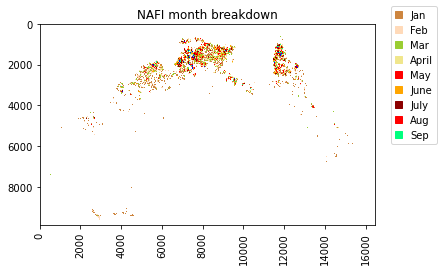

In [17]:
NAFI_reclass = copy.copy(NAFI_array)
NAFI_reclass[np.where(NAFI_array== 0)] = 0 # No fire
NAFI_reclass[np.where((NAFI_array>=1) & (NAFI_array<=8))] = 1 #  Class Jan
NAFI_reclass[np.where((NAFI_array>=8) & (NAFI_array<=16))] = 2 #  Class Feb
NAFI_reclass[np.where((NAFI_array>=17) & (NAFI_array<=26))] = 3 # March
NAFI_reclass[np.where((NAFI_array>=27) & (NAFI_array<=36))] = 4 #  April
NAFI_reclass[np.where((NAFI_array>=37) & (NAFI_array<=55))] = 5 #  Class May
NAFI_reclass[np.where((NAFI_array>=56) & (NAFI_array<=84))] = 6 #  Class June
NAFI_reclass[np.where((NAFI_array>=85) & (NAFI_array<=115))] = 7 #  Class July
NAFI_reclass[np.where((NAFI_array>=116) & (NAFI_array<=145))] = 8 #  Class August
NAFI_reclass[np.where((NAFI_array>=146) & (NAFI_array<=175))] = 9 #  Class September
NAFI_reclass[np.where((NAFI_array>=176) & (NAFI_array<=205))] = 10 #  Class October
NAFI_reclass[np.where((NAFI_array>=206) & (NAFI_array<=231))] = 11 #  Class November
NAFI_reclass[np.where((NAFI_array>=232) & (NAFI_array<=255))] = 12 #  Class December
NAFI_reclass[np.where(NAFI_array>=176)] = 255 #  Class No data
"""NAFI_reclass[np.where((NAFI_array>206) & (NAFI_array<=231))] = 11 #  Class November
NAFI_reclass[np.where((NAFI_array>232) & (NAFI_array<=254))] = 12 #  Class December"""
#NAFI_reclass[np.where(NAFI_array== 0)] = 10 # Class No data

print('Min:',np.nanmin(NAFI_reclass))
print('Max:',np.nanmax(NAFI_reclass))
print('Mean:',round(np.nanmean(NAFI_reclass),2))


import matplotlib.colors as colors
plt.figure(); #ax = plt.subplots()
cmapNAFI = colors.ListedColormap([
    'white',
    'peru',
    'peachpuff',
    'yellowgreen',
    'khaki',
    'red',
    'orange',
    'darkred',
    'red',
    'springgreen',
    'blue',
    'tan',
    'maroon',
    'red',
])

extents=[6000,1200,0,500]

plt.imshow(NAFI_reclass,  cmap=cmapNAFI) #extent=extents,
plt.title('NAFI month breakdown')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
# forceAspect(ax,aspect=1) # ax.set_aspect('auto')

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='peru', label='Jan')
class2_box = mpatches.Patch(color='peachpuff', label='Feb')
class3_box = mpatches.Patch(color='yellowgreen', label='Mar')
class4_box = mpatches.Patch(color='khaki', label='April')
class5_box = mpatches.Patch(color='red', label='May')
class6_box = mpatches.Patch(color='orange', label='June')
class7_box = mpatches.Patch(color='darkred', label='July')
class8_box = mpatches.Patch(color='red', label='Aug')
class9_box = mpatches.Patch(color='springgreen', label='Sep')
class10_box = mpatches.Patch(color='blue', label='Oct')
class11_box = mpatches.Patch(color='tan', label='Nov')
class12_box = mpatches.Patch(color='maroon', label='Dec')
class13_box = mpatches.Patch(color='black', label='255')
#class14_box = mpatches.Patch(color='black', label='255')



ax.legend(handles=[class1_box,class2_box,class3_box,class4_box, class5_box, class6_box,
                  class7_box,class8_box,class9_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

Export geo tif

In [24]:

"""
Array to Raster Function from https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html)
"""
import gdal, osr #ogr, os, osr
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    print(originX)
    originY = rasterOrigin[1]
    print(originY)


    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4283)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [25]:
epsg = 4283   # GDA94 
rasterOrigin = (NAFI_metadata['ext_dict']['xMin'],NAFI_metadata['ext_dict']['yMax'])
print('raster origin:',rasterOrigin)
array2raster('Z:\Scratch\Zonal_Stats_Pipeline\Firescars\scratch\test2020v7.tif',rasterOrigin,1,-1,NAFI_reclass,epsg)

raster origin: (112.9225, -9.329999999999998)
112.9225
-9.329999999999998


AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'

Full classification code

In [26]:
# raster2array.py reads in the first band of geotif file and returns an array and associated 
# metadata dictionary

import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
import numpy as np
import copy
#import matplotlib.colors as colors
import gdal, osr #ogr, os, osr
import numpy as np



def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
        
NAFI_array, NAFI_metadata = raster2array(r"Z:\Scratch\Zonal_Stats_Pipeline\Firescars\NAFI_fire_rasters_v2\fs2020.tif")

print('NAFI_Array: ',NAFI_array)

#print metadata in alphabetical order
for item in sorted(NAFI_metadata):
    print(item + ':', NAFI_metadata[item])

NAFI_reclass = copy.copy(NAFI_array)
NAFI_reclass[np.where(NAFI_array== 0)] = 0 # Class No data
NAFI_reclass[np.where((NAFI_array>=1) & (NAFI_array<=8))] = 1 #  Class Jan
NAFI_reclass[np.where((NAFI_array>=8) & (NAFI_array<=16))] = 2 #  Class Feb
NAFI_reclass[np.where((NAFI_array>=17) & (NAFI_array<=26))] = 3 # March
NAFI_reclass[np.where((NAFI_array>=27) & (NAFI_array<=36))] = 4 #  April
NAFI_reclass[np.where((NAFI_array>=37) & (NAFI_array<=55))] = 5 #  Class May
NAFI_reclass[np.where((NAFI_array>=56) & (NAFI_array<=84))] = 6 #  Class June
NAFI_reclass[np.where((NAFI_array>=85) & (NAFI_array<=115))] = 7 #  Class July
NAFI_reclass[np.where((NAFI_array>=116) & (NAFI_array<=145))] = 8 #  Class August
NAFI_reclass[np.where((NAFI_array>=146) & (NAFI_array<=175))] = 9 #  Class September
NAFI_reclass[np.where((NAFI_array>=176) & (NAFI_array<=205))] = 10 #  Class October
NAFI_reclass[np.where((NAFI_array>=206) & (NAFI_array<=231))] = 11 #  Class November
NAFI_reclass[np.where((NAFI_array>=232) & (NAFI_array<=254))] = 12 #  Class December
NAFI_reclass[np.where(NAFI_array==255)] = 255 #  Class No data


print('Min:',np.nanmin(NAFI_reclass))
print('Max:',np.nanmax(NAFI_reclass))
print('Mean:',round(np.nanmean(NAFI_reclass),2))

ax.legend(handles=[class1_box,class2_box,class3_box,class4_box, class5_box, class6_box,
                  class7_box,class8_box,class9_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)


"""
Array to Raster Function from https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html)
"""


def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    
    pixelWidth = 0.0025
    print(pixelWidth)
    
    print('------------------------------------------------------------------------')

    pixelHeight = -0.0025
    print(pixelHeight)

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

epsg = 4283   # GDA94 
rasterOrigin = (NAFI_metadata['ext_dict']['xMin'],NAFI_metadata['ext_dict']['yMax'])
print('raster origin:',rasterOrigin)
array2raster('Z:\Scratch\Zonal_Stats_Pipeline\Firescars\scratch\test2020v8.tif',rasterOrigin,1,-1,NAFI_reclass,epsg)
print('----------------------\n script has finished \n ----------------')

NAFI_Array:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
array_cols: 16431
array_rows: 9868
bands: 1
bandstats: {'min': 0.0, 'max': 157.0, 'mean': 1.03, 'stdev': 9.61}
driver: GeoTIFF
ext_dict: {'xMin': 112.9225, 'xMax': 6572512.9225, 'yMin': -3947209.33, 'yMax': -9.329999999999998}
extent: (112.9225, 6572512.9225, -3947209.33, -9.329999999999998)
geotransform: (112.9225, 0.0025, 0.0, -9.329999999999998, 0.0, -0.0025)
noDataValue: 255.0
pixelHeight: -0.0025
pixelWidth: 0.0025
projection: 
scaleFactor: 1.0
Min: 0.0
Max: 9.0
Mean: 0.08
raster origin: (112.9225, -9.329999999999998)
0.0025
------------------------------------------------------------------------
-0.0025


AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'